In [1]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import anndata
import mudata
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyvis.network import Network
from matplotlib.patches import ArrowStyle
from scipy.stats import fisher_exact
import seaborn as sns
from scipy.stats import hypergeom
import glob
import scanpy as sc
from statsmodels.stats.multitest import multipletests


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
# celltype = 'STR_D1_GABA'
# gender = 'M'
outdir = '/data2st1/junyi/output/atac0627/snregulation/'
# df_grn = pd.read_csv(f'/data1st1/yejun/pyscenic/grn/adj_{celltype}_{gender}.tsv',sep='\t')
overwrite= False

In [3]:
def fisher_TF2gene(metadata_df, TF_selected, df_dar_ct,df_deg_ct):
    """
    Perform Fisher's exact test for TF-DAR-gene interactions.

    Parameters:
        metadata_df: DataFrame with columns ['TF', 'Gene', 'importance_TF2G']
        TF_col: Column name for transcription factors
        gene_col: Column name for genes
        weight_col: Column name for importance scores
    """
    # Subset the metadata for the selected TF
    direct_er_s = metadata_df[metadata_df['TF'] == TF_selected]
    df_dar_tmp = df_dar_ct.copy()
    df_deg_tmp = df_deg_ct.copy()
    df_dar_tmp['regulation'] = -1
    df_dar_tmp.loc[df_dar_tmp['de_coef']>0,'regulation'] = 1
    df_dar_reg = df_dar_tmp[['names','regulation']].rename(columns={'names': 'Region'})
    df_deg_tmp['regulation'] =  -1
    df_deg_tmp.loc[df_deg_tmp['de_coef']>0,'regulation'] = 1
    df_deg_tmp.rename(columns={'gene': 'Gene'}, inplace=True)
    direct_dar = direct_er_s.merge(df_dar_reg,how='left', left_on='Region', right_on='Region', suffixes=('', '_dar'))
    direct_dar.fillna({'regulation_dar': 0}, inplace=True)
    direct_dar_deg = direct_dar.merge(df_deg_tmp[['Gene','regulation']], how='left', left_on='Gene', right_on='Gene', suffixes=('', '_deg'))
    direct_dar_deg.fillna({'regulation_deg': 0}, inplace=True)
    direct_dar_deg['regulation_TF'] = -1
    direct_dar_deg.loc[direct_dar_deg['eRegulon_name'].str.contains('\+\/\+'), 'regulation_TF'] = 1
    #direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_TF'] * direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']
    direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']

    # DEG and DAR
    a = len(direct_dar_deg[direct_dar_deg['real_regulation'] == 1].drop_duplicates(subset=['Region']))
    # DAR but not DEG
    b = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_dar'] != 0)].drop_duplicates(subset=['Region']))
    # DEG but not DAR
    c = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_deg'] != 0)].drop_duplicates(subset=['Region']))
    # Neither DEG nor DAR
    #d = len(direct_dar_deg) - a - b - c
    d = len(direct_dar_deg[(direct_dar_deg['regulation_dar'] == 0) & (direct_dar_deg['regulation_deg'] == 0)].drop_duplicates(subset=['Region']))
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
    return odds_ratio, p_value


In [4]:
def visualize_regulatory_network(metadata_df, importance_col='importance', weight_col='importance_TF2G',figure_size=(7, 7),
                               top_n=100, output_html='figures/network.html',title='SCENIC+ Regulatory Network',df_deg=None):
    """
    Visualize SCENIC+ regulatory network with TF-gene relationships
    
    Parameters:
        metadata_df: DataFrame with columns ['TF', 'gene', importance_col, 'region']
        importance_col: Column name for TF-gene importance scores
        top_n: Number of top interactions to visualize
        output_html: Output file name for interactive visualization
    """
    # Prepare data
    # Sort by the absolute importance and select top_n interactions

    df = metadata_df.sort_values(importance_col, ascending=False).head(top_n)
    #df = metadata_df.sort_values(importance_col, ascending=False)
    
    # Create network graph
    G = nx.DiGraph()
    
    # Add nodes and edges with importance as weight
    for _, row in df.iterrows():
        G.add_edge(row['TF'], row['Gene'], 
                  weight=row[weight_col],
                  title=f"Importance: {row[weight_col]:.2f}")
        
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees else 1

    
    # Node colors (TFs in red, genes in blue)
    # Node colores, where TFs are orange and genes are magenta, not in df_deg are gray

    node_colors = {}
    node_edge_colors = {}
    node_edge_widths = {}

    for node in G.nodes():
        if node in df['TF'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = '#F6607C'
                node_edge_colors[node] = '#F6607C'  # Light red outline
                node_edge_widths[node] = 3
            else:
                node_colors[node] = '#B2DF8A'
                node_edge_colors[node] = '#B2DF8A'  # Light green outline
                node_edge_widths[node] = 3

        elif node in df['Gene'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'lightcoral'
                node_edge_colors[node] = 'lightcoral'
                node_edge_widths[node] = 3

            else:
                node_colors[node] = '#D2ECBB'
                node_edge_colors[node] = '#D2ECBB'
                node_edge_widths[node] = 3

        else:
            node_colors[node] = 'lightgray'  # For nodes not in df_deg
            node_edge_colors[node] = 'lightgray'
            node_edge_widths[node] = 0


    # node_colors = {
    #     node: 'orange' if node in df['TF'].unique() else 'magenta'
    #     for node in G.nodes()
    # }
    
    # Static visualization
    plt.figure(figsize=figure_size)
    pos = nx.spring_layout(G, k=0.1, iterations=50,scale=0.5)
    #pos = nx.kamada_kawai_layout(G, scale=0.8)
    
    # Draw nodes


    #node_sizes_d = [degrees[n] * 800 / max_degree for n in G.nodes()]
    #node size = abs log2 fold change in df_deg
    node_sizes = []
    for n in G.nodes():
        if n in df_deg['gene'].unique():
            fold_change = df_deg[df_deg['gene'] == n]['de_coef'].values[0]
            node_sizes.append(abs(fold_change) * 400 + degrees[n]*400 / max_degree)
        else:
            node_sizes.append(100)

    # node_sizes = [degrees[n] * 800 / max_degree for n in G.nodes()]
    # nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()],
    #                                edgecolors=[node_edge_colors[n] for n in G.nodes()],
    #                 linewidths=[node_edge_widths[n] for n in G.nodes()],
    #                       node_size=node_sizes, alpha=0.8)


    node_shapes = {n: 'h' if n in df['TF'].unique() else 'o' for n in G.nodes()}

# 分批次绘制不同形状的节点
    for shape in set(node_shapes.values()):
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[n for n in G.nodes() if node_shapes[n] == shape],
            node_shape=shape,
            node_color=[node_colors[n] for n in G.nodes() if node_shapes[n] == shape],
            edgecolors=[node_edge_colors[n] for n in G.nodes() if node_shapes[n] == shape],
            linewidths=[node_edge_widths[n] for n in G.nodes() if node_shapes[n] == shape],
            node_size=[node_sizes[i] for i, n in enumerate(G.nodes()) if node_shapes[n] == shape],
            alpha=0.8
        )


    # Draw edges with width proportional to importance
    edge_widths = [d['weight']*2 for u, v, d in G.edges(data=True)]
    # nx.draw_networkx_edges(G, pos, width=edge_widths, 
    #                       edge_color='gray', alpha=0.6, 
    #                       arrowstyle='-|>', arrowsize=15)
    for u, v, d in G.edges(data=True):
        arrowstyle = '-|>' if d['weight'] >= 0 else '|-|'
        color = '#FBC2C3' if d['weight'] >= 0 else '#D2ECBB'
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=abs(d['weight'])*4,
            edge_color=color,
            alpha=0.6,
            arrowstyle=arrowstyle,
             connectionstyle="arc3, rad=0.2",
            arrowsize=15
        )
    import matplotlib.patheffects as path_effects

    # Draw labels
    text_labels = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif',bbox=dict(facecolor='none',  pad=0.1, edgecolor='none'))
    for _, label in text_labels.items():
        label.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_html+".png", dpi=300)
    plt.show()
    
    # Interactive visualization
    net = Network(height='800px', width='100%', directed=True)
    net.from_nx(G)


    for node in net.nodes:
        if node['id'] in df['TF'].unique():
            node['shape'] = 'triangle'

    # Save interactive version
    net.show_buttons(filter_=['physics'])
    net.save_graph(output_html)
    print(f"Interactive visualization saved to {output_html}")

In [5]:
def split_umap(adata, split_by, ncol=2, nrow=None, **kwargs):
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    axs = axs.flatten()
    for i, cat in enumerate(categories):
        ax = axs[i]
        sc.pl.umap(adata[adata.obs[split_by] == cat], ax=ax, show=False, title=cat, **kwargs)
    plt.tight_layout()


In [6]:
cac_gene_dict = {'α1 subunit': ['Cacna1a',
  'Cacna1b',
  'Cacna1c',
  'Cacna1d',
  'Cacna1e',
  'Cacna1g',
  'Cacna1h',
  'Cacna1i'],
 'α2δ subunit': ['Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4'],
 'β subunit': ['Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4'],
 'γ subunit': ['Cacng2', 'Cacng3', 'Cacng4', 'Cacng5', 'Cacng7', 'Cacng8'],
 'None': ['Cacfd1', 'Cachd1']}

ca_genes = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d', 'Cacna1e', 'Cacna1g', 
            'Cacna1h', 'Cacna1i', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 
            'Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4', 'Cacng2', 'Cacng3', 'Cacng4', 
            'Cacng5', 'Cacng7', 'Cacng8', 'Cacfd1', 'Cachd1']


ligand = ['Slc18a2', 'Slc18a1', 'Ddc', 'Th', 'Slc17a7', 'Slc17a8', 'Gls',
       'Slc17a6', 'Slc18a3', 'Chat', 'Slc32a1', 'Dbh', 'Tph2', 'Tph1', 'Gad2',
       'Gad1', 'Pnmt', 'Shmt2', 'Shmt1', 'Hmox2', 'Nos3', 'Hmox1', 'Cort',
       'Nos2', 'Nos1', 'Sst', 'Adcyap1', 'Rln1', 'Nrxn3', 'Npy', 'Nrxn2',
       'Nrxn1', 'Pdyn', 'Vip', 'Trh', 'Crh', 'Nts', 'Penk', 'Tac1', 'Pthlh',
       'Pnoc', 'Tac2', 'Gjc1', 'Gjc2', 'Gjc3', 'Gjd2', 'Gjd3', 'Gjd4', 'Gje1',
       'Gjb6', 'Gjb5', 'Gjb4', 'Gjb3', 'Gjb2', 'Gjb1', 'Gja8', 'Gja6', 'Cck',
       'Grp', 'Gja5', 'Gja4', 'Gja1', 'Gja3', 'Gja10', 'Nmb']

receptor = ['Oprl1', 'Gabra6', 'Grik3', 'Gabrb3', 'Grik5', 'Adrb1', 'Oprd1', 'Gabra4', 
            'Grm5', 'Drd4', 'Npy1r', 'Grin2c', 'Slc6a4', 'Gjc3', 'Chrna7', 'Rxfp1', 'Adra1b', 
            'Gjb1', 'Oprm1', 'Nlgn2', 'Drd5', 'Chrm5', 'Gabra1', 'Htr5a', 'Pth1r', 'Oprk1', 'Tacr3', 
            'Chrna1', 'Grm7', 'Grik2', 'Chrna6', 'Adra1a', 'Gucy1b2', 'Slc6a3', 'Adra2b', 'Gabbr1', 'Chrna4', 
            'Gjb4', 'Htr1b', 'Gja1', 'Npy2r', 'Gucy1a1', 'Gabrb1', 'Grin1', 'Adra2a', 'Tacr1', 'Adrb2', 'Sstr2', 
            'Grin3a', 'Glra2', 'Slc6a2', 'Drd3', 'Htr1d', 'Adra2c', 'Htr2c', 'Grin2d', 'Chrnb1', 'Chrnb2', 'Gja4', 'Htr7', 
            'Htr2b', 'Gabra3', 'Ache', 'Grik4', 'Htr6', 'Grm1', 'Sstr4', 'Gjb2', 'Grm6', 'Adcyap1r1', 'Adra1d', 'Gria2', 
            'Chrna2', 'Grm3', 'Grik1', 'Chrm3', 'Rxfp3', 'Chrna10', 'Chrng', 'Gjb3', 'Crhr2', 'Grin3b', 'Gria3', 'Vipr1', 'Gria1', 
            'Grin2b', 'Htr4', 'Slc6a9', 'Npy5r', 'Gja3', 'Htr1f', 'Chrnb3', 'Gjd4', 'Nlgn3', 'Gjd2', 'Grm4', 'Sstr1', 'Grin2a', 'Gabrg2', 
            'Adrb3', 'Grm2', 'Gja8', 'Glra3', 'Gje1', 'Comt', 'Sstr3', 'Gjb5', 'Gabra2', 'Rxfp2', 'Chrne', 'Gabrg3', 'Vipr2', 'Cckbr', 'Htr1a', 
            'Chrm2', 'Gucy1a2', 'Htr2a', 'Ntsr2', 'Ntsr1', 'Htr3b', 'Gabrb2', 'Gja6', 'Drd2', 'Glra1', 'Grm8', 'Chrnd', 'Nmbr', 'Glrb', 'Trhr', 
            'Gria4', 'Gja5', 'Chrna9', 'Gucy1b1', 'Nlgn1', 'Drd1', 'Gjc1', 'Glra4', 'Crhr1', 'Chrna5', 'Gjc2', 'Gjd3', 'Trhr2', 'Gabra5', 'Htr1e', 
            'Htr3a', 'Slc6a5', 'Gja10', 'Chrna3', 'Chrm4', 'Gjb6', 'Chrnb4', 'Chrm1', 'Gabrg1', 'Gabbr2', 'Grpr']


respriotory = ['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Atp6', 'mt-Nd4', 'mt-Nd1', 'Cox6c',
       'Cox8a', 'Cox4i1', 'Sdha', 'Ndufa4', 'Ndufs4', 'Cox7c', 'Ndufc2',
       'Ndufaf7', 'Ndufa13', 'Atp5f1', 'Ndufaf4', 'Cox7a2', 'Cox7b', 'Cox6a1',
       'Ndufs1', 'Ndufv2', 'Ndufb5', 'Uqcrh', 'Uqcrc2', 'Ndufaf2', 'Ndufb9',
       'Cox5a', 'Ndufa10', 'Ndufb1-ps', 'mt-Nd2', 'Ndufa6', 'Cox5b', 'Ndufb11',
       'Ndufb3', 'Cox6b1', 'Ndufs3', 'Uqcrq', 'Cyc1', 'Ndufb4', 'Coq2', 'Sdhb',
       'Ndufa7', 'Ndufs7', 'Ndufa12', 'Ndufb8', 'Ndufa11', 'Ndufb10', 'Ndufa3',
       'Coa3', 'Uqcrb', 'Ndufab1', 'Ndufa5', 'Uqcrc1', 'Sod2', 'Uqcr11',
       'Uqcr10', 'Sdhc', 'Ndufb2', 'Ndufa2', 'Ndufv3', 'Ndufs2', 'Ndufa1',
       'Ndufb7', 'Cycs', 'Ndufv1', 'Ndufa8', 'Coq3', 'Ndufc1', 'Ndufa9',
       'Coq5', 'Ndufb6', 'Coq8b', 'Ndufs8', 'Ndufaf5', 'Coq9', 'Ndufaf6',
       'Ndufs6', 'Tfam', 'mt-Nd3', 'mt-Nd5', 'Coq4', 'Sdhd', 'Coq7', 'Ndufaf3',
       'mt-Nd4l', 'Coa5', 'Coa7', 'Cox6a2', 'Cox4i2']

In [7]:
regions = ['HPF','Isocortex', 'AMY',
       'PFC', 'TH', 'STR',  'HY', 'MB']

            DEGs    Non-DEGs	Total
    ​DARs​	    a	    b	        a+b
​Non-DARs​	    c	    d	        c+d
    ​Total  ​	a+c	    b+d	          N

In [8]:
df_deg = pd.read_csv("/data2st1/junyi/data/127_DEGs overlap/Overlapped_DEGs_Merge_L2_each_region_diff_gender_padj05.csv",index_col=0)

In [9]:
# df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
# df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
# df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
# df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
# df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
# df_deg = df_deg[df_deg['gender'] == "M"]
# df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]
# df_deg['condition'] = 'DOWN'
# df_deg.loc[df_deg.de_coef>0,'condition'] = 'UP'

In [10]:
df_tvalues = pd.read_excel('/data2st1/junyi/data/pyscenic/aucell_t_values_merged_filtered.xlsx',index_col=0)
df_pvalues = pd.read_excel('/data2st1/junyi/data/pyscenic/aucell_p_values_merged_filtered.xlsx',index_col=0)

In [11]:
df_tvalues.index = df_tvalues.index.str.replace(r"[+)()]",'').str.replace(r" ", '')
df_pvalues.index = df_pvalues.index.str.replace(r"[+)()]",'').str.replace(r" ", '')

/tmp/ipykernel_1404405/3717635225.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tvalues.index = df_tvalues.index.str.replace(r"[+)()]",'').str.replace(r" ", '')
/tmp/ipykernel_1404405/3717635225.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_pvalues.index = df_pvalues.index.str.replace(r"[+)()]",'').str.replace(r" ", '')


In [12]:
df_pvalues.fillna(1, inplace=True)

In [13]:
df_tmelt = pd.melt(df_tvalues, ignore_index=False,var_name='celltype', value_name='AUC_t')
df_tmelt = df_tmelt[df_tmelt['AUC_t'] != 0]
df_tmelt['TF'] = df_tmelt.index

In [14]:
df_pmelt = pd.melt(df_pvalues, ignore_index=False,var_name='celltype', value_name='AUC_p')
df_pmelt = df_pmelt[df_pmelt['AUC_p'] <0.05]

In [15]:
df_pmelt['celltype'] = df_pmelt['celltype'].str.replace("auc_","")
df_pmelt['TF'] = df_pmelt.index

In [16]:
df_sign_table = df_pmelt.merge(df_tmelt, how='inner',left_on=['TF','celltype'], right_on=['TF','celltype'])

In [17]:
df_deg['celltype.L2']= df_deg['celltype'].str.replace(' ','_').str.replace('/','_')
df_deg['celltype.L2_gender'] = df_deg['celltype.L2'] + '_' + df_deg['gender']

In [18]:
set(df_deg['celltype.L2_gender']).difference(df_sign_table['celltype'].unique())

set()

In [19]:
df_grns = glob.glob(f'/data1st1/yejun/pyscenic/grn/adj_*.tsv')

In [20]:
def fisher_targetDEG(df_input,df_deg,df_grn,n_universe=30804):
    df_targetudcont = df_input.copy() 
    dfdeg_ct_gender = df_deg
    dfdeTF_grn = df_grn
    for index, row in df_targetudcont.iterrows():
        r_TF = index
        a_up = row['Up']
        a_down = row['Down']
        # Is the TF target but not DEG
        b_up = len(set(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target).difference(set(dfdeg_ct_gender[dfdeg_ct_gender.status=='Up'].gene)))
        b_down = len(set(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target).difference(set(dfdeg_ct_gender[dfdeg_ct_gender.status=='Down'].gene)))
        # Is DEG but not the TF target
        c_up = len((set(dfdeg_ct_gender[dfdeg_ct_gender.status=='Up'].gene)).difference(set(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target)))
        c_down = len((set(dfdeg_ct_gender[dfdeg_ct_gender.status=='Down'].gene)).difference(set(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target)))
        # Neither DEG nor the TF target
        # d_up = len((set(dfdeg_ct_gender[dfdeg_ct_gender.status!='Up'].gene)).difference(set(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target)))
        # d_down = len((set(dfdeg_ct_gender[dfdeg_ct_gender.status!='Down'].gene)).difference(set(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target)))
        d_up = n_universe - a_up - b_up - c_up
        d_down = n_universe - a_down - b_down - c_down
        # FISHER's exact test
        table = [[a_up, b_up], [c_up, d_up]]
        odds_ratio_up, p_value_up = fisher_exact(table, alternative='greater')
        table = [[a_down, b_down], [c_down, d_down]]
        odds_ratio_down, p_value_down = fisher_exact(table, alternative='greater')
        # add the odds_ratio and p_value to the df_targetudcont
        df_targetudcont.loc[index, 'odds_ratio_up'] = odds_ratio_up
        df_targetudcont.loc[index, 'p_value_up'] = p_value_up
        df_targetudcont.loc[index, 'odds_ratio_down'] = odds_ratio_down
        df_targetudcont.loc[index, 'p_value_down'] = p_value_down
    #print(f"TF: {r_TF}, Up: {odds_ratio_up}, {p_value_up}")    
    return df_targetudcont

def hypergeom_targetDEG(df_input,df_deg,df_grn,n_universe=30804):
    df_targetudcont = df_input.copy() 
    dfdeg_ct_gender = df_deg
    dfdeTF_grn = df_grn
    for index, row in df_targetudcont.iterrows():
        r_TF = index
        a_up = row['Up']
        a_down = row['Down']
        # Is the TF target but not DEG
        n_Up = len(dfdeg_ct_gender.status == 'Up')
        n_Down = len(dfdeg_ct_gender.status == 'Down')
        n_target = len(dfdeTF_grn[dfdeTF_grn.TF==r_TF].target.unique())

        # FISHER's exact test
        p_value_up = hypergeom.sf(a_up - 1, n_universe, n_target, n_Up)
        p_value_down = hypergeom.sf(a_down - 1, n_universe, n_target, n_Down)

        # add the odds_ratio and p_value to the df_targetudcont
        # df_targetudcont.loc[index, 'odds_ratio_up'] = odds_ratio_up
        df_targetudcont.loc[index, 'p_value_up'] = p_value_up
        # df_targetudcont.loc[index, 'odds_ratio_down'] = odds_ratio_down
        df_targetudcont.loc[index, 'p_value_down'] = p_value_down
    #print(f"TF: {r_TF}, Up: {odds_ratio_up}, {p_value_up}")    
    return df_targetudcont


In [21]:
if (True == overwrite):
    for file in df_grns:
        region = file.split("adj_")[1].split("_")[0]
        gender = file.split(".")[0].split("_")[-1]
        celltype = file.split("adj_")[1].replace(f'_{gender}.tsv','')

        # region = 'TH'
        # gender = 'M'
        # celltype = 'Tnc_Adgrf5_Glut'
        df_grn = pd.read_csv(file, sep='\t')
        dfdeg_ct_gender = df_deg[(df_deg['celltype.L2']==celltype) & (df_deg['gender']==gender)]
        dfdeTF_grn = df_grn[df_grn.TF.isin(dfdeg_ct_gender.gene)]
        df_TFtarget_count = dfdeTF_grn.groupby('TF').size().reset_index(name='count')
        df_TFtarget_count.set_index('TF', inplace=True)
        df_dedt_grn = dfdeTF_grn.merge(dfdeg_ct_gender, left_on='target',right_on='gene', how='inner')
        df_targetudcont = df_dedt_grn.groupby(['TF','status']).size().reset_index(name='n').pivot(index='TF',columns='status',values='n').fillna(0).astype(int)

        if 'Up' not in df_targetudcont.columns:
            df_targetudcont['Up'] = 0
        if 'Down' not in df_targetudcont.columns:
            df_targetudcont['Down'] = 0
        try:
            df_targetudcont['%targetDown'] = df_targetudcont['Down'].values / df_TFtarget_count.loc[df_targetudcont.index,'count'].values * 100
        except KeyError:
            print(f"KeyError: {df_targetudcont.index} not in df_TFtarget_count index",file)
            df_targetudcont['%targetDown'] = 0.0
        try:
            df_targetudcont['%targetUp'] = df_targetudcont['Up'].values / df_TFtarget_count.loc[df_targetudcont.index,'count'].values * 100
        except KeyError:
            print(f"KeyError: {df_targetudcont.index} not in df_TFtarget_count index",file)
            df_targetudcont['%targetUp'] = 0.0
        df_targetudcont['celltype'] = celltype
        df_targetudcont['gender'] = gender
        df_targetudcont['#target'] = df_TFtarget_count.loc[df_targetudcont.index,'count'].values

        df_targetudcont = hypergeom_targetDEG(df_targetudcont, dfdeg_ct_gender, dfdeTF_grn)

        #df_result = df_targetudcont[['celltype','gender','#target','%targetDown','%targetUp']].sort_values(by=['%targetDown','%targetUp'], ascending=False)
        df_result = df_targetudcont

        
        df_result.to_csv(f'{outdir}/{celltype}_{gender}_TFtarget_analysis.csv')

In [ ]:
if (not os.path.exists(f'{outdir}/TFtarget_analysis_ovlp_significant_selected.csv')) | (True == overwrite):
    results_fils = glob.glob(f'{outdir}/*_TFtarget_analysis.csv')
    results_all = pd.DataFrame()
    for file in results_fils:
        df_result = pd.read_csv(file)
        results_all = pd.concat([results_all, df_result], axis=0, ignore_index=True)
    results_all['ctype_gender'] = results_all['celltype'] + '_' + results_all['gender']
    # set_no_result = set(df_deg['celltype.L2_gender']).difference(results_all['ctype_gender'].unique())
    # df_deg[df_deg['celltype.L2_gender'].isin(set_no_result)].groupby('celltype.L2_gender').count().sort_values(by='gene_name', ascending=False)
    result_ovlp = results_all.merge(df_sign_table, how='inner', right_on=['TF','celltype'], left_on=['TF','ctype_gender'], suffixes=('', '_sign'))
    result_ovlp = result_ovlp.merge(df_deg.loc[:,['gene','celltype.L2_gender','de_coef','de_pval']],how='left', left_on=['TF','ctype_gender'], right_on=['gene','celltype.L2_gender'])
    result_ovlp.sort_values(by='AUC_t', ascending=True, inplace=True)
    #result_ovlp.to_csv(f'{outdir}/TFtarget_analysis_ovlp_significant.csv', index=False)
    result_ovlp['reguconstist'] = (result_ovlp['de_coef'] * result_ovlp['AUC_t'])>0
    result_ovlp_selected = result_ovlp[result_ovlp['reguconstist'] == True]
    result_ovlp_selected.sort_values(by='AUC_t', ascending=False, inplace=True)
    result_ovlp_selected['regulation'] = 'Up'
    result_ovlp_selected.loc[result_ovlp_selected['de_coef'] < 0,'regulation'] = 'Down'
    result_ovlp_selected['region'] = result_ovlp_selected['celltype'].str.split('_').str[0]
    result_ovlp_selected.loc[~result_ovlp_selected['region'].isin(regions),'region'] = 'Other'
    result_ovlp_selected.to_csv(f'{outdir}/TFtarget_analysis_ovlp_significant_selected.csv', index=False)
else:
    result_ovlp_selected = pd.read_csv(f'{outdir}/TFtarget_analysis_ovlp_significant_selected.csv')

In [25]:
len(result_ovlp_selected.TF.unique())

275

In [31]:
region_info = result_ovlp_selected.groupby(['region','gender','regulation']).nunique()['TF'].reset_index()

<Figure size 1000x600 with 0 Axes>

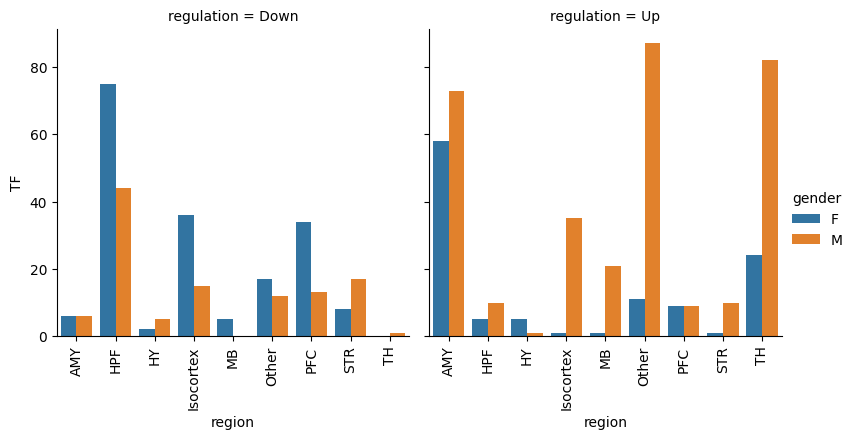

In [48]:
# figure size of catplot of sns
plt.figure(figsize=(10, 6))
# why the plt.figure(figsize not work?
# sns.catplot(data=region_info, x='region', y='TF', hue='gender', col='regulation', kind='bar', height=4, aspect=0.7)
sns.catplot(data=region_info, x='region', y='TF', hue='gender', col='regulation', kind='bar', height=4, aspect=1)
# rotate x-axis labels for all catsubplot
for ax in plt.gcf().axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

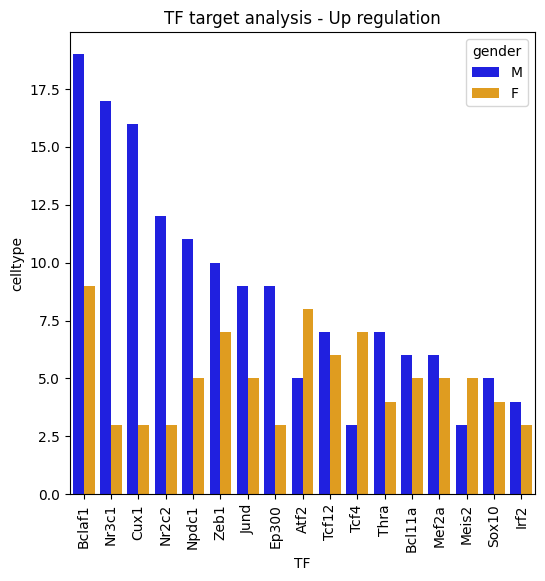

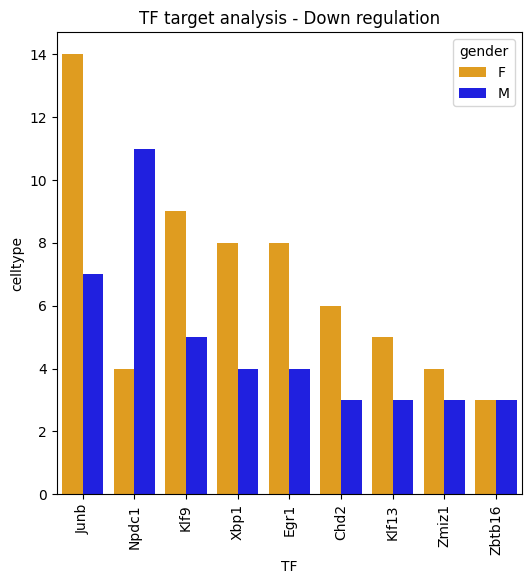

In [52]:
def gen_result(result_ovlp_selected,by_col='celltype',regulation ='Up',n_threshold=2,overlap =True): 
    df_all_results= pd.DataFrame()
    M_Finterset = set()
    for gender in ['M','F']:
        regulation = regulation
        dfresult_tmp = result_ovlp_selected[(result_ovlp_selected.gender==gender) & 
                                        (result_ovlp_selected.regulation==regulation)].groupby('TF').nunique()[by_col].reset_index()
        dfresult_tmp['gender'] = gender
        dfresult_tmp['regulation'] = regulation
        dfresult_tmp = dfresult_tmp[dfresult_tmp[by_col].abs() > n_threshold]

        #dfresult_tmp['celltype'] = dfresult_tmp['celltype'] * dfresult_tmp['regulation']
        df_all_results = pd.concat([df_all_results, dfresult_tmp], axis=0)

        if M_Finterset == set():
            M_Finterset = set(dfresult_tmp['TF'].unique())
        else:
            M_Finterset = M_Finterset.intersection(set(dfresult_tmp['TF'].unique()))

    df_all_results.sort_values(by=by_col, ascending=True, inplace=True)
    # select TF with absolute celltype > 2
    #df_all_results_selected = df_all_results[df_all_results[by_col].abs() > n_threshold]

    if overlap:
        # select TF with overlap in M and F
        df_all_results_selected = df_all_results[df_all_results['TF'].isin(M_Finterset)]
    # select up regulation
    else:
        df_all_results_selected = df_all_results
    df_all_results_selected.sort_values(by=by_col, ascending=False, inplace=True)


    return df_all_results_selected

dict_result = {}
for reg in ['Up','Down']:

    result_plot = gen_result(result_ovlp_selected,by_col='celltype',regulation=reg,overlap=True)
    dict_result[reg] = result_plot
    plt.figure(figsize=(6, 6))

    # set the color of male to blue and female to orange
    palette = {'M': 'blue', 'F': 'orange'}
    sns.barplot(data=result_plot, x='TF', y='celltype', hue='gender', palette=palette)
    #plot title
    plt.title(f'TF target analysis - {reg} regulation')
    # rotate x-axis labels
    plt.xticks(rotation=90)

In [68]:
# fix the colormap of brain regions
region_palette = {
    'HPF': '#1f77b4',  # blue
    'Isocortex': '#ff7f0e',  # orange
    'AMY': '#2ca02c',  # green
    'PFC': '#d62728',  # red
    'TH': '#9467bd',  # purple
    'STR': '#8c564b',  # brown
    'HY': '#e377c2',  # pink
    'MB': '#7f7f7f',  # gray
    'Other': '#bcbd22'  # yellow-green
}

In [78]:
dict_result[reg]

,TF,celltype,gender,regulation
51,Junb,14,F,Down
48,Npdc1,11,M,Down
57,Klf9,9,F,Down
107,Xbp1,8,F,Down
26,Egr1,8,F,Down
28,Junb,7,M,Down
19,Chd2,6,F,Down
34,Klf9,5,M,Down
56,Klf13,5,F,Down
118,Zmiz1,4,F,Down


In [82]:
df_TFss

,TF,celltype,gender,regulation
51,Junb,14,F,Down
57,Klf9,9,F,Down
107,Xbp1,8,F,Down
26,Egr1,8,F,Down
19,Chd2,6,F,Down


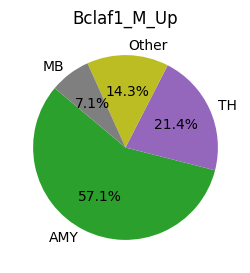

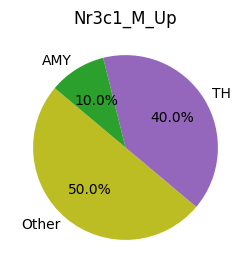

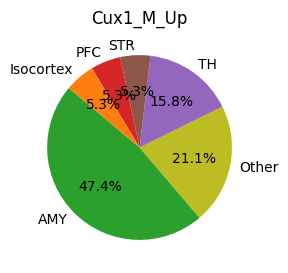

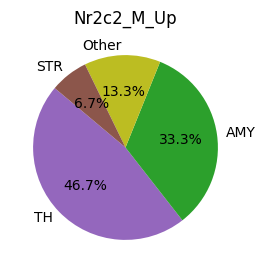

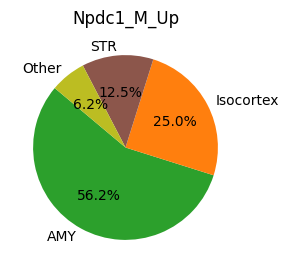

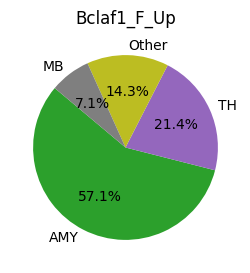

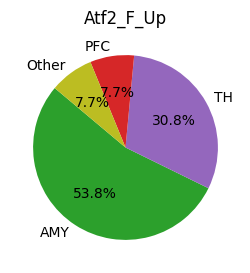

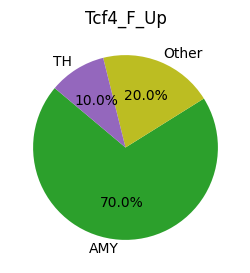

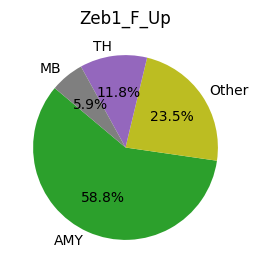

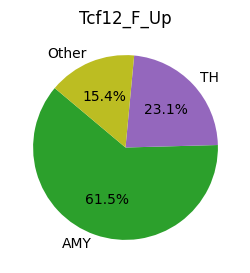

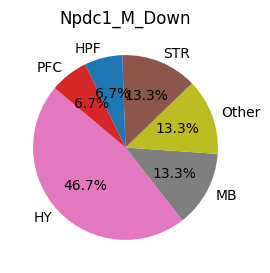

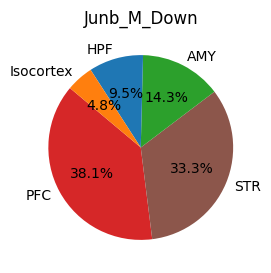

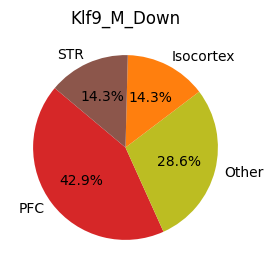

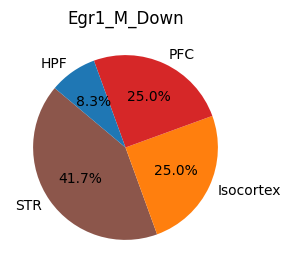

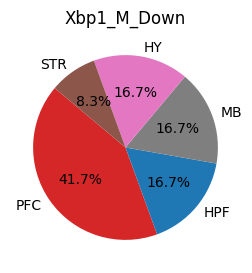

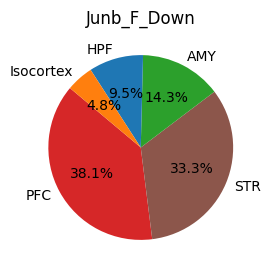

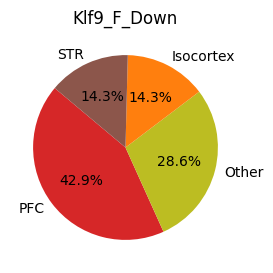

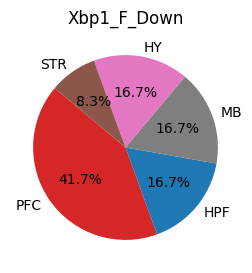

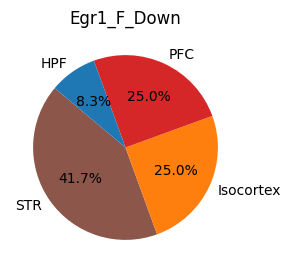

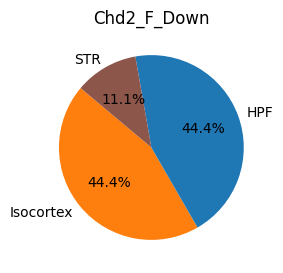

In [ ]:
# Draw pies charts with subplots,
# EACH TF in a pie chart, with the region distribution of the TF
top_n = 5  # Number of top TFs to visualize

for reg in ['Up','Down']:
    df_TFs = dict_result[reg]
    for gender in ['M','F']:
        df_TFss = df_TFs[df_TFs.gender == gender]
        df_TFss = df_TFss.sort_values(by='celltype',ascending=False).head(top_n)
        for index,row in df_TFss.iterrows():
            TF = row['TF']
            celltype = row['celltype']
            gender = row['gender']
            regulation = row['regulation']
            df_TFSELECTED = result_ovlp_selected[(result_ovlp_selected.TF==TF) & 
                                                    (result_ovlp_selected.regulation==regulation)]
            
            # draw a piechart of the region distribution of the TF
            region_counts = df_TFSELECTED['region'].value_counts()

            
            plt.figure(figsize=(3, 3))
            plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=140, colors=[region_palette.get(x, '#333333') for x in region_counts.index])
            plt.title(f'{TF}_{gender}_{regulation}')

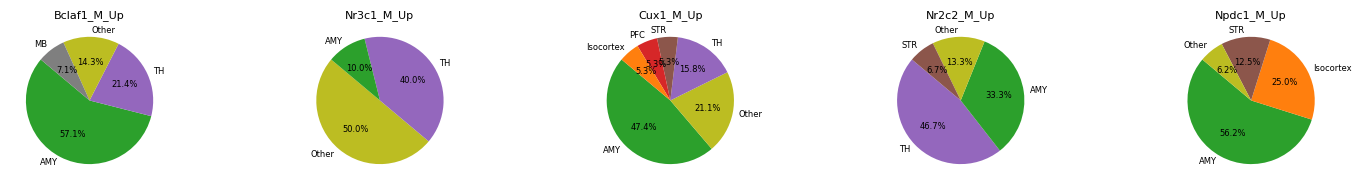

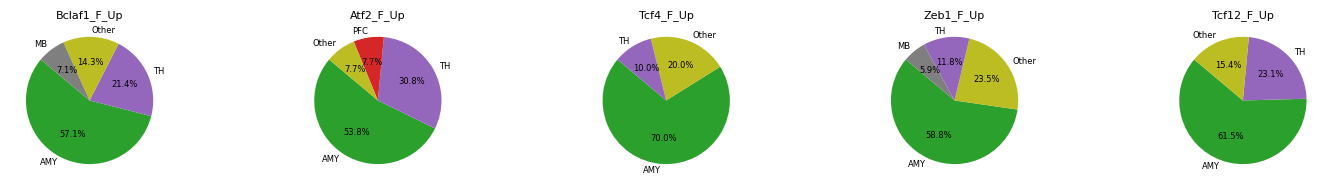

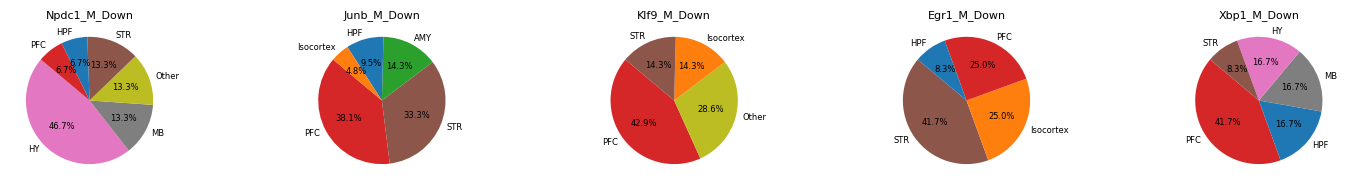

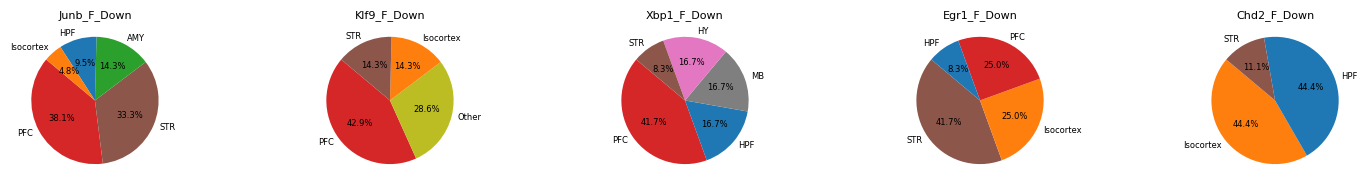

In [88]:
import matplotlib.pyplot as plt
import math

top_n = 5  # Number of top TFs to visualize
plots_per_row = 5  # Adjust as needed

for reg in ['Up', 'Down']:
    df_TFs = dict_result[reg]
    for gender in ['M', 'F']:
        # Filter and sort TFs
        df_TFss = df_TFs[df_TFs.gender == gender]
        df_TFss = df_TFss.sort_values(by='celltype', ascending=False).head(top_n)
        
        # Calculate rows needed (5 plots per row)
        num_plots = len(df_TFss)
        rows = math.ceil(num_plots / plots_per_row)
        
        # Create subplot grid
        fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, 2 * rows))
        axes = axes.flatten()  # Flatten for easy indexing
        
        # Plot each TF's pie chart
        for idx, (_, row) in enumerate(df_TFss.iterrows()):
            TF = row['TF']
            regulation = row['regulation']
            df_TFSELECTED = result_ovlp_selected[
                (result_ovlp_selected.TF == TF) & 
                (result_ovlp_selected.regulation == regulation)
            ]
            
            # Get region counts and colors
            region_counts = df_TFSELECTED['region'].value_counts()
            colors = [region_palette.get(x, '#333333') for x in region_counts.index]
            
            # Plot pie chart in subplot
            ax = axes[idx]
            ax.pie(
                region_counts, 
                labels=region_counts.index, 
                autopct='%1.1f%%', 
                startangle=140, 
                colors=colors,
                textprops={'fontsize': 6}  # Smaller labels for tight spaces
            )
            ax.set_title(f'{TF}_{gender}_{regulation}', fontsize=8, pad=2)  # Compact title
        
        # Hide unused subplots
        for i in range(num_plots, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()


In [61]:
df_TFSELECTED

,TF,Down,Up,%targetDown,%targetUp,celltype,gender,#target,p_value_up,p_value_down,...,celltype_sign,AUC_p,AUC_t,gene,celltype.L2_gender,de_coef,de_pval,reguconstist,regulation,region
934,Zbtb16,320,306,6.968641,6.663763,HPF_CA1_Glut,M,4592,0.000743,2.040583e-05,...,HPF_CA1_Glut_M,5.594938e-18,-8.651041,Zbtb16,HPF_CA1_Glut_M,-0.078139,4.246695e-06,True,Down,HPF
968,Zbtb16,50,41,1.261352,1.034309,HPF_Subiculum_SUB_Glut,M,3964,0.006691,2.258947e-05,...,HPF_Subiculum_SUB_Glut_M,8.080333e-22,-10.013349,Zbtb16,HPF_Subiculum_SUB_Glut_M,-0.543647,7.009030e-11,True,Down,HPF
1095,Zbtb16,855,257,14.085667,4.233937,HPF_DG_GC_Glut,M,6070,1.000000,7.211872e-156,...,HPF_DG_GC_Glut_M,4.028311e-73,-18.133751,Zbtb16,HPF_DG_GC_Glut_M,-0.107325,1.896079e-11,True,Down,HPF


In [ ]:
adata_sc = sc.read_h5ad("/data1st1/sch/20250626/anndata_before_intergration_anno.h5ad")

In [ ]:
df_TF_summary = pd.read_excel('/data2st1/junyi/output/atac0627/dar/region_nt/tf_summary.xlsx',index_col=0)

In [ ]:
top_up_TFs = df_TF_summary.sort_values(by="Up_celltypes_num", ascending=False).head(5).index.tolist()
top_down_TFs = df_TF_summary.sort_values(by="Down_celltypes_num", ascending=False).head(5).index.tolist()

In [ ]:
df_auc = pd.read_csv('/data1st2/yejun/pyscenic/auc_merge.txt', sep='\t', index_col=0)
# For all columns remove the suffix (+)
df_auc.columns = df_auc.columns.str.replace(r'[\+\(\)]', '', regex=True)
df_auc = df_auc.loc[adata_sc.obs.index]
for TF in top_up_TFs + top_down_TFs:
    adata_sc.obs[f'AUC_{TF}'] = df_auc[TF].values

In [ ]:
adata_sc.obs['celltype.L2.gender'] = adata_sc.obs['celltype.L2'].str.replace(' ', '_').str.replace('/', '_') + '_' + adata_sc.obs['sex'].astype(str)

In [ ]:
for TF in top_up_TFs + top_down_TFs:
    adata_sc.obs[f'AUCtval_{TF}'] = 0

    for celltype in adata_sc.obs['celltype.L2.gender'].unique():
        value =  df_tvalues.loc[TF, celltype]
        if TF in df_tvalues.index:
            adata_sc.obs.loc[adata_sc.obs['celltype.L2.gender'] == celltype, f'AUCtval_{TF}'] = df_tvalues.loc[TF, celltype]

In [ ]:
# Calculate centroids for cell type labels
def get_centroids(adata, groupby):
    from scipy.sparse import issparse
    # if issparse(adata.X):
    #     X = adata.X.toarray()
    # else:
    #     X = adata.X
    centroids = []
    labels = []
    for cluster in adata.obs[groupby].unique():
        mask = adata.obs[groupby] == cluster
        centroids.append(adata.obsm['X_umap'][mask].mean(0))
        labels.append(cluster)
    return np.array(centroids), labels


In [ ]:
adata_sc.obs['region_nt'] = adata_sc.obs['region'].astype('str') + "_" + adata_sc.obs['Neurotransmitter_celltype'].fillna('NN').str[:4]
adata_sc.obs.loc[adata_sc.obs['region_nt'].str.contains('NN'),'region_nt'] = adata_sc.obs.loc[adata_sc.obs['region_nt'].str.contains('NN'),'celltype.L1']

In [ ]:
import matplotlib.patheffects as path_effects

centroids, labels = get_centroids(adata_sc, 'region_nt')

# If centroids too close, randomly add a small value to x and y coordinates
# if np.all(np.abs(np.diff(centroids[:, 0])) < 0.1
#         and np.all(np.abs(np.diff(centroids[:, 1])) < 0.1):
#centroids[:, 0] += np.random.uniform(-3, 3, size=centroids.shape[0])
# centroids[:, 1] += np.random.uniform(-3, 3, size=centroids.shape[0])

import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist

def optimize_coordinates(X_original, alpha=0.5):
    """
    Optimize coordinates to balance min pairwise distance and displacement from original
    
    Parameters:
        X_original: numpy array of shape (n_points, n_dimensions)
        alpha: float between 0 and 1 controlling tradeoff between objectives
               (0 = only minimize displacement, 1 = only maximize min distance)
    """
    n_points, n_dim = X_original.shape
    
    def objective(X_flat):
        X = X_flat.reshape(n_points, n_dim)
        
        # Calculate minimum pairwise distance (to maximize)
        pairwise_dists = pdist(X)
        min_dist = np.min(pairwise_dists) if len(pairwise_dists) > 0 else 0
        
        # Calculate displacement from original (to minimize)
        displacement = np.sum(cdist(X, X_original, 'sqeuclidean'))
        
        # Combined objective (convert maximization to minimization)
        return -alpha * min_dist + (1-alpha) * displacement
    
    # Initial guess (original coordinates)
    x0 = X_original.flatten()
    
    # Bounds (optional - constrain movement within some range)
    bounds = [(x-1, x+1) for x in x0]  # Example: ±1 unit from original
    
    # Run optimization
    result = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')
    
    return result.x.reshape(n_points, n_dim)

def iterative_repulsion(X_original, max_iter=100, repulsion_strength=0.1):
    X = X_original.copy()
    for _ in range(max_iter):
        # Calculate all pairwise distances
        dists = cdist(X, X)
        np.fill_diagonal(dists, np.inf)  # Ignore self-distances
        
        # Find closest pairs
        min_dists = np.min(dists, axis=1)
        closest_indices = np.argmin(dists, axis=1)
        
        # Move points away from their closest neighbor
        for i in range(len(X)):
            if min_dists[i] > 0:  # Only move if not coincident
                direction = X[i] - X[closest_indices[i]]
                unit_direction = direction / np.linalg.norm(direction)
                X[i] += repulsion_strength * unit_direction * (1 - min_dists[i])
        
        # Optional: Add attraction back to original position
        X = 0.9*X + 0.1*X_original
    
    return X
# centroids[:, 0] += np.random.uniform(-3, 3, size=centroids.shape[0])
#centroids[:, 1] += np.random.uniform(-4, 4, size=centroids.shape[0])


# for each centroid, if its idstance to the closest centroid is less than a threshold, move it randomly
def simple_relocate(centroids, max_iter=100, threshold=3):
    for _ in range(max_iter):
        dists = cdist(centroids, centroids)
        np.fill_diagonal(dists, np.inf)
        min_dists = np.min(dists, axis=1)
        closest_indices = np.argmin(dists, axis=1)
        for i in range(len(centroids)):
            if min_dists[i] < threshold:
                # Move centroid randomly within a small radius
                centroids[i] += np.random.uniform(-1, 1, size=centroids.shape[1])
                #centroids[:, 1] += np.random.uniform(-0.5, 0.5, size=centroids.shape[0])
    return centroids

#centroids = optimize_coordinates(centroids, alpha=0.5)
#centroids = simple_relocate(centroids, max_iter=100, threshold=1)
# centroids = iterative_repulsion(centroids, max_iter=100, repulsion_strength=0.1)
#centroids = optimize_coordinates(centroids, alpha=0.5)


In [ ]:

for tf in top_up_TFs + top_down_TFs:
    #adata_sc.obs[f'AUCtval_{TF}'] = 0
    fig, ax = plt.subplots(figsize=(8, 6))
    sc.pl.umap(adata_sc, color=f'AUCtval_{tf}', ax=ax, show=False,  frameon=False, vmax=10, vmin=-10, cmap='coolwarm')
    for i, txt in enumerate(labels):
        text = ax.text(centroids[i, 0], centroids[i, 1], txt, 
                fontsize=8, weight='bold',
                # bbox=dict(facecolor='white', alpha=0.2, edgecolor='white')
                )
        text.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='white'),
        path_effects.Normal()])

    plt.tight_layout()
    #plt.show()
    plt.savefig(f'/data2st1/junyi/output/atac0627/umap_tval_{tf}.png', dpi=300)
    plt.close()

In [ ]:
def split_umap(adata, split_by,centroids,labels, ncol=2, nrow=None, **kwargs):
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(8*ncol, 6*nrow))
    axs = axs.flatten()
    color_bar = 0
    colorbar = False
    for i, cat in enumerate(categories):
        ax = axs[i]
        color_bar +=1
        if (color_bar % nrow) == 0:
            colorbar=True
        sc.pl.umap(adata[adata.obs[split_by] == cat], ax=ax, show=False, frameon=False, cmap='coolwarm', title=cat, **kwargs)

        for i, txt in enumerate(labels):
            text = ax.text(centroids[i, 0], centroids[i, 1], txt, 
                    fontsize=8, weight='bold',
                    # bbox=dict(facecolor='white', alpha=0.2, edgecolor='white')
                    )
            text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground='white'),
            path_effects.Normal()])

    plt.tight_layout()
    


In [ ]:
split_umap(adata_sc, 'sex',centroids=centroids, labels=labels, ncol=2, nrow=1,  vmax=10, vmin=-10,color=f'AUCtval_{tf}')

In [ ]:
for tf in top_up_TFs + top_down_TFs:
    split_umap(adata_sc, split_by='sex',nrow=1,centroids=centroids,labels=labels,color=f'AUCtval_{tf}')
    plt.savefig(f'/data2st1/junyi/output/atac0627/umap_tval_{tf}_split_by_sex.pdf', dpi=300)
    plt.close()

In [ ]:
adata_sc.obs['UMAP1'] = adata_sc.obsm['X_umap'][:, 0]
adata_sc.obs['UMAP2'] = adata_sc.obsm['X_umap'][:, 1]

In [ ]:
adata_sc.obs.to_csv(f'{outdir}/adata_sc_obs_with_AUC.csv')

In [ ]:
sc.pl.umap(adata_sc, color=[f'AUCtval_{TF}' for TF in top_up_TFs + top_down_TFs], save='_top_TF_AUCtval.png',vmax=10,vmin=-10,cmap='coolwarm',ncols=5)

In [ ]:
df_tvalues_top = df_tvalues.loc[top_up_TFs + top_down_TFs]

In [ ]:
df_tvalues_to_clip = df_tvalues_top.clip(lower=-10,upper=10)

In [ ]:
sns.heatmap(df_tvalues_to_clip.T, cmap='coolwarm', center=0)

In [ ]:
class DummyFile(object):
    def write(self, x): pass
    def flush(self): pass

sys.stdout = DummyFile()
sys.stderr = DummyFile()

def genes_heatmap(tmp,genes,order=None,figsize=(24,12),title=None):
    if len(genes)<30 and figsize[1]<30:
        plt.figure(figsize=(12,12))
    else:
        plt.figure(figsize=figsize)
    genes=pd.Series(genes)
    # Filter the DataFrame based on the input Nal
    tmp1 = tmp.loc[genes[genes.isin(tmp.index)]].T
    if order:
        tmp1=tmp1.loc[order,:]
    else:
        correlation_matrix=tmp1
        linkage_rows = sch.linkage(correlation_matrix, method='ward')
        linkage_cols = sch.linkage(correlation_matrix.T, method='ward')
        
        # Get the order of the clusters
        row_order = sch.leaves_list(linkage_rows)
        col_order = sch.leaves_list(linkage_cols)
        
        # Reorder the correlation matrix
        tmp1 = correlation_matrix.iloc[row_order, col_order]
    
    tmp1.replace(0, np.nan, inplace=True)
    heatmap = sns.heatmap(tmp1, cmap='coolwarm', center=0)
    heatmap.set_xticks(np.arange(tmp1.shape[1]) + 0.5)
    heatmap.set_xticklabels(tmp1.columns, rotation=90, ha='center')
    heatmap.set_yticks(np.arange(tmp1.shape[0]) + 0.5)
    heatmap.set_yticklabels(tmp1.index)
    
    if title:
        tmp1.to_csv(f'figures/path/{title}.csv')
        plt.title(title)
        plt.savefig(f'figures/path/{title}.pdf',dpi=300, bbox_inches='tight',transparent=True)
        sys.stdout = open('tmp.log', 'w')
        sys.stderr = open('tmp.log', 'w') 
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = sys.__stdout__
        sys.stderr = sys.__stderr__
    plt.show()

In [ ]:
adata_selected = adata_sc[adata_sc.obs.region.isin(["PFC"]) #& adata_sc.obs.status.isin(['W']) 
                          #& adata_sc.obs.sex.isin(['M']) 
                          & (adata_sc.obs.Neurotransmitter_celltype.isin(['Glutamatergic','GABAergic']))]

In [ ]:
def split_umap(adata, split_by, ncol=2, nrow=None, **kwargs):
    vmax_val = adata.obs[kwargs.get('color', [])[0]].max()
    vim_val = adata.obs[kwargs.get('color', [])[0]].min()
    categories = adata.obs[split_by].cat.categories
    if nrow is None:
        nrow = int(np.ceil(len(categories) / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(5*ncol, 4*nrow))
    axs = axs.flatten()
    for i, cat in enumerate(categories):
        ax = axs[i]
        # Do not show the bar of color

        sc.pl.umap(adata[adata.obs[split_by] == cat],frameon=False, ax=ax, show=False,color_map='plasma',vmax=10,vmin=-10,size=10, title=cat, **kwargs)
    plt.tight_layout()


In [ ]:
sc.pl.umap(adata_selected, color=['AUCtval_Junb'], frameon=False, title='AUC Bclaf1',color_map='plasma')

In [ ]:
split_umap(adata_selected, split_by='sex', color=['AUCtval_Junb3+-'])

In [ ]:
sc.pl.umap(adata_selected, color=['celltype.L2'], frameon=False, title='AUC_Egr1',color_map='plasma', size=10,palette='Set1')

In [ ]:
sc.pl.umap(adata_selected, color=['AUC_Klf9'], frameon=False, title='AUC_Egr1',color_map='plasma', size=10)

In [ ]:
results_all['target_status'] = 'Neu'
results_all.loc[results_all['sigUp'], 'target_status'] = 'Up'
results_all.loc[results_all['sigDown'], 'target_status'] = 'Down'
results_all.loc[results_all['sigDown'] & results_all['sigUp'], 'target_status'] = 'Both'



In [ ]:
results_all['region'] = results_all['celltype'].str.split('_').str[0]

In [ ]:
results_all_group = results_all.groupby(['TF','target_status','gender']).size().reset_index(name='count').pivot(index='TF', columns=['target_status','gender'])
results_all_group.columns = results_all_group.columns.map('_'.join)
results_all_group.fillna(0, inplace=True)
results_all_group = results_all_group.astype(int)



In [ ]:
results_all_group['Sign_F'] = results_all_group['count_Down_F'] + results_all_group['count_Up_F']
results_all_group['Sign_M'] = results_all_group['count_Down_M'] + results_all_group['count_Up_M']
results_all_group['Sign_ALL'] = results_all_group['Sign_F'] + results_all_group['Sign_M']

In [ ]:
results_all_group.sort_values(by='Sign_ALL', ascending=False, inplace=True)

In [ ]:
results_all_group

In [ ]:
df_TFDEstatus = df_deg[df_deg.gene.isin(results_all_group.index)].groupby(['gene','status','gender']).nunique()['celltype'].reset_index().pivot(index='gene', columns=['status','gender'], values='celltype')
df_TFDEstatus.columns = df_TFDEstatus.columns.map('_'.join)
df_TFDEstatus.fillna(0, inplace=True)
df_TFDEstatus = df_TFDEstatus.astype(int)



In [ ]:
df_TFDEstatus['sign_F'] = df_TFDEstatus['Up_F'] + df_TFDEstatus['Down_F']
df_TFDEstatus['sign_M'] = df_TFDEstatus['Up_M'] + df_TFDEstatus['Down_M']
df_TFDEstatus['sign_ALL'] = df_TFDEstatus['sign_F'] + df_TFDEstatus['sign_M']

In [ ]:
df_TFDEstatus.head()

In [ ]:
rename_map = {
    'Up_F': 'TF_#CT_Up_F',
    'Down_F': 'TF_#CT_Down_F',
    'Up_M': 'TF_#CT_Up_M',
    'Down_M': 'TF_#CT_Down_M',
    'sign_F': 'TF_#CT_F',
    'sign_M': 'TF_#CT_M',
    'sign_ALL': 'TF_#CT'
}
df_TFDEstatus.rename(columns=rename_map, inplace=True)

# df_TFDEstatus.columns=[
#     'TF_#CT_Down_F', 'TF_#CT_Down_M',
#     'TF_#CT_Up_F', 'TF_#CT_Up_M',
#     'TF_#CT_F', 'TF_#CT_M',
#     'TF_#CT'
# ]
# df_TFDEstatus.head()

In [ ]:
results_all_group.head(5)

In [ ]:
rename_map = {
    'count_Down_F': 'Target_#CT_Down_F',
    'count_Neu_F': 'Target_#CT_Neu_F',
    'count_Up_F': 'Target_#CT_Up_F',
    'count_Down_M': 'Target_#CT_Down_M',
    'count_Neu_M': 'Target_#CT_Neu_M',
    'count_Up_M': 'Target_#CT_Up_M',
    'Sign_F': 'Target_#CT_F',
    'Sign_M': 'Target_#CT_M',
    'Sign_ALL': 'Target_#CT'
}
results_all_group.rename(columns=rename_map, inplace=True)


In [ ]:
df_TF_statmerge = df_TFDEstatus.merge(results_all_group, left_index=True, right_index=True, how='right',suffixes=('_TF', '_target'))

In [ ]:
df_TF_statmerge.columns

In [ ]:
df_TF_statmerge.sort_values(by='TF_#CT', ascending=False, inplace=True)

In [ ]:
df_TF_statmerge

In [ ]:
results_region_selected = results_all[results_all.region.isin(df_deg.region.unique())]

In [ ]:
df_TF_statmerge

In [ ]:
for index, row in df_TF_statmerge.iterrows():

    id_tf=index
    for gender in ['F', 'M']:
        dfdeg_selected = df_deg[(df_deg.gene == id_tf) & (df_deg.gender==gender)]
        up_cts = "/".join(dfdeg_selected.loc[dfdeg_selected.status=='Up','celltype.L2'].values.tolist())
        down_cts = "/".join(dfdeg_selected.loc[dfdeg_selected.status=='Down','celltype.L2'].values.tolist())
        region_up_c = dfdeg_selected.loc[dfdeg_selected.status=='Up'].groupby('region').size().reset_index(name='count')
        up_region_c = "/".join(list(region_up_c['region']+':'+region_up_c['count'].astype(str).values))
        region_down_c = dfdeg_selected.loc[dfdeg_selected.status=='Down'].groupby('region').size().reset_index(name='count')
        down_region_c = "/".join(list(region_down_c['region']+':'+region_down_c['count'].astype(str).values))
        df_TF_statmerge.loc[index, f'TF_CT_Up_{gender}'] = up_cts
        df_TF_statmerge.loc[index, f'TF_CT_Down_{gender}'] = down_cts
        df_TF_statmerge.loc[index, f'TF_#CT/Region_Up_{gender}'] = up_region_c
        df_TF_statmerge.loc[index, f'TF_#CT/Region_Down_{gender}'] = down_region_c

        dftarget_selected = results_region_selected[(results_region_selected.TF == id_tf) & (results_region_selected.gender == gender)]
        target_u_cts = "/".join(dftarget_selected.loc[dftarget_selected.target_status=='Up','celltype'].values.tolist())
        target_d_cts = "/".join(dftarget_selected.loc[dftarget_selected.target_status=='Down','celltype'].values.tolist())
        target_u_region_c = dftarget_selected.loc[dftarget_selected.target_status=='Up'].groupby('region').size().reset_index(name='count')
        target_up_region_c = "/".join(list(target_u_region_c['region']+':'+target_u_region_c['count'].astype(str).values))
        target_d_region_c = dftarget_selected.loc[dftarget_selected.target_status=='Down'].groupby('region').size().reset_index(name='count')
        target_down_region_c = "/".join(list(target_d_region_c['region']+':'+target_d_region_c['count'].astype(str).values))
        df_TF_statmerge.loc[index, f'Target_#CT/Up_{gender}'] = target_u_cts
        df_TF_statmerge.loc[index, f'Target_#CT/Down_{gender}'] = target_d_cts
        df_TF_statmerge.loc[index, f'Target_#CT/Region_Up_{gender}'] = target_up_region_c
        df_TF_statmerge.loc[index, f'Target_#CT/Region_Down_{gender}'] = target_down_region_c


In [ ]:
df_TF_statmerge

In [ ]:
df_TF_statmerge.to_csv(f'{outdir}/TF_target_DEG_stat_merge_new.csv')

In [ ]:
df_summary_auc = pd.read_excel('/data2st1/junyi/output/atac0627/snregulation/pyscenic_result_summary.xlsx', index_col=0)

In [ ]:
df_summary_auc.index = df_summary_auc.index.str.replace(r"[+)()]",'')

In [ ]:
df_summary_auc.columns
# columns in the summary file are
# ['Upregulated_Cells', 'upregulated_num_F', 'upregulated_num_M',
#        'Downregulated_Cells', 'downregulated_num_F', 'Unnamed: 6',
#        'downregulated_num_M', 'F_up_region_num', 'M_up_region_num',
#        'F_down_region_num', 'M_down_region_num', 'F_up_region_count',
#        'F_down_region_count', 'M_up_region_count', 'M_down_region_count']

rename_map = {
    'Upregulated_Cells': 'AUC_CT_Up',
    'upregulated_num_F': 'AUC_#CT_Up_F',
    'upregulated_num_M': 'AUC_#CT_Up_M',
    'Downregulated_Cells': 'AUC_CT_Down',
    'downregulated_num_F': 'AUC_#CT_Down_F',
    'downregulated_num_M': 'AUC_#CT_Down_M',
    'F_down_region_num': 'AUC_#CT/Region_Down_F',
    'M_down_region_num': 'AUC_#CT/Region_Down_M',
    'F_up_region_num': 'AUC_#CT/Region_Up_F',
    'M_up_region_num': 'AUC_#CT/Region_Up_M',
    'F_up_region_count': 'AUC_#Region_Up_F_count',
    'F_down_region_count': 'AUC_#Region_Down_F_count',
    }
df_summary_auc.rename(columns=rename_map, inplace=True)

In [ ]:
df_summary_auc_merge = df_summary_auc.merge(df_TF_statmerge, left_index=True, right_index=True, how='right', suffixes=('_auc', '_TFtarget'))

In [ ]:
# order the columns, numeric columns first, then string columns
numeric_cols = df_summary_auc_merge.select_dtypes(include=['number']).columns.tolist()
string_cols = df_summary_auc_merge.select_dtypes(include=['object']).columns.tolist()

# Sort numerical columns contains TF first, then target, then AUC
tf_cols = [col for col in numeric_cols if col.startswith('TF_')]
target_cols = [col for col in numeric_cols if col.startswith('Target_')]
auc_cols = [col for col in numeric_cols if col.startswith('AUC_')]

# Sort string columns that contains TF first, then target, then AUC 
tf_string_cols = [col for col in string_cols if col.startswith('TF_')]
target_string_cols = [col for col in string_cols if col.startswith('Target_')]
auc_string_cols = [col for col in string_cols if col.startswith('AUC_')]

# Combine all columns in the desired order
ordered_cols = (
    numeric_cols + 
    tf_cols + 
    target_cols + 
    auc_cols + 
    string_cols + 
    tf_string_cols + 
    target_string_cols + 
    auc_string_cols
)   
df_summary_auc_merge = df_summary_auc_merge[ordered_cols]
                   


In [ ]:
df_summary_auc_merge.to_csv(f'{outdir}/TF_target_DEG_stat_merge_auc_new.csv')

In [ ]:
n_TFs = len(df_grn.TF.unique())
n_targets = len(df_grn.target.unique())

In [ ]:
print(f"Number of TFs: {n_TFs}, Number of targets: {n_targets}")

In [ ]:
n_deTF= dfdeTF_grn.TF.unique().shape[0]
n_deTFtargets = dfdeTF_grn.target.unique().shape[0]

In [ ]:
print(f"Number of de TFs: {n_deTF}, Number of targets: {n_deTFtargets}")

In [ ]:
dfdeTFdt_grn = dfdeTF_grn[dfdeTF_grn.target.isin(dfdeg_ct_gender.gene)]

In [ ]:
ndedtTF = dfdeTFdt_grn.TF.unique().shape[0]
ndedtTFtargets = dfdeTFdt_grn.target.unique().shape[0]

In [ ]:
# dfdeg_ct_gender_up = dfdeg_ct_gender[dfdeg_ct_gender['status'] == 'Up']
# dfdeg_ct_gender_down = dfdeg_ct_gender[dfdeg_ct_gender['status'] == 'Down']
# n_dedeTFtargets_up= dfdeg_ct_gender_up[dfdeg_ct_gender_up.gene.isin(dfdeTFdt_grn.target.unique())].gene.unique().shape[0]
# n_dedeTFtargets_down= dfdeg_ct_gender_down[dfdeg_ct_gender_down.gene.isin(dfdeTFdt_grn.target.unique())].gene.unique().shape[0]

In [ ]:
n_dedeTFtargets_up + n_dedeTFtargets_down

In [ ]:
print(f"Number of deTFs targeting degs: {ndedtTF}, Number of de targets: {ndedtTFtargets}")

In [ ]:
df_ndeTF2target = dfdeTF_grn.groupby('TF').count()['importance']

In [ ]:
df_ndedtTF2target = dfdeTFdt_grn.groupby('TF').count()['importance']

In [ ]:
df_ndeTF2target.reset_index()

In [ ]:
df_TFpctDEG= df_ndedtTF2target.div(df_ndeTF2target).sort_values(ascending=False).reset_index()
df_TFpctDEG

In [ ]:
dfdeTFdt_grn

In [ ]:
dTF_deg_merge = dfdeTFdt_grn.merge(dfdeg_ct_gender,left_on='TF', right_on='gene', how='inner')

In [ ]:
dfdeg_ct_gender

In [ ]:
nTF_up = dTF_deg_merge.drop_duplicates(subset=['TF'])['status'].value_counts()['Up']
nTF_down = dTF_deg_merge.drop_duplicates(subset=['TF'])['status'].value_counts()['Down']

In [ ]:
# sort df_tvalues by the sum of each column, so that the larger positive values in the matrix upper left
# larger negative values in the matrix lower right
# set the value between -2 and 2 to 0
df_tvalues = df_tvalues.mask((df_tvalues > -2) & (df_tvalues < 2), 0)

col_idx = (df_tvalues!=0).sum(axis=0).sort_values(ascending=False).index
row_idx = (df_tvalues!=0).sum(axis=1).sort_values(ascending=False).head(100).index



# idx = df_tvalues.sum(axis=1).sort_values(ascending=False).index
# idx_col = df_tvalues.sum(axis=0).sort_values(ascending=False).index
# remove the rows less than 10 celltypes
df_plot = df_tvalues.loc[:,col_idx]
df_plot = df_plot.loc[row_idx,:]

idx = df_plot.sum(axis=1).sort_values(ascending=False).index
idx_col = df_plot.sum(axis=0).sort_values(ascending=False).index

df_plot = df_plot.loc[idx,idx_col]

df_plot = df_plot.clip(lower=-5,upper=5)

In [ ]:
(df_tvalues!=0).sum(axis=1).sort_values(ascending=False).head()

In [ ]:
sns.heatmap(df_plot, cmap='coolwarm', center=0)

In [ ]:
def fisher_TF2gene(metadata_df, TF_selected, df_dar_ct,df_deg_ct):
    """
    Perform Fisher's exact test for TF-DAR-gene interactions.

    Parameters:
        metadata_df: DataFrame with columns ['TF', 'Gene', 'importance_TF2G']
        TF_col: Column name for transcription factors
        gene_col: Column name for genes
        weight_col: Column name for importance scores
    """
    # Subset the metadata for the selected TF
    direct_er_s = metadata_df[metadata_df['TF'] == TF_selected]
    df_dar_tmp = df_dar_ct.copy()
    df_deg_tmp = df_deg_ct.copy()
    df_dar_tmp['regulation'] = -1
    df_dar_tmp.loc[df_dar_tmp['de_coef']>0,'regulation'] = 1
    df_dar_reg = df_dar_tmp[['names','regulation']].rename(columns={'names': 'Region'})
    df_deg_tmp['regulation'] =  -1
    df_deg_tmp.loc[df_deg_tmp['de_coef']>0,'regulation'] = 1
    df_deg_tmp.rename(columns={'gene': 'Gene'}, inplace=True)
    direct_dar = direct_er_s.merge(df_dar_reg,how='left', left_on='Region', right_on='Region', suffixes=('', '_dar'))
    direct_dar.fillna({'regulation_dar': 0}, inplace=True)
    direct_dar_deg = direct_dar.merge(df_deg_tmp[['Gene','regulation']], how='left', left_on='Gene', right_on='Gene', suffixes=('', '_deg'))
    direct_dar_deg.fillna({'regulation_deg': 0}, inplace=True)
    direct_dar_deg['regulation_TF'] = -1
    direct_dar_deg.loc[direct_dar_deg['eRegulon_name'].str.contains('\+\/\+'), 'regulation_TF'] = 1
    #direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_TF'] * direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']
    direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']

    # DEG and DAR
    a = len(direct_dar_deg[direct_dar_deg['real_regulation'] == 1].drop_duplicates(subset=['Region']))
    # DAR but not DEG
    b = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_dar'] != 0)].drop_duplicates(subset=['Region']))
    # DEG but not DAR
    c = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_deg'] != 0)].drop_duplicates(subset=['Region']))
    # Neither DEG nor DAR
    #d = len(direct_dar_deg) - a - b - c
    d = len(direct_dar_deg[(direct_dar_deg['regulation_dar'] == 0) & (direct_dar_deg['regulation_deg'] == 0)].drop_duplicates(subset=['Region']))
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
    return odds_ratio, p_value


In [ ]:
cellltypes = ['PFC_PFC_GABA', 
              'AMY_AMY_GABA', 'HIP_HIP_GABA',
              'PFC_PFC_Glut', 'AMY_AMY_Glut', 'HIP_HIP_Glut'
              ]
df_fisher_all = pd.DataFrame()
df_enahcner_all = pd.DataFrame()
for cellltype in cellltypes:
    ctname = cellltype[4:]
    df_deg_select = df_deg[df_deg['ctname'] == ctname]
    oudir = f'/data1st2/junyi/output/atac0416/scenic/{cellltype}/Snakemake'
    #scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

    #direct_er = scplus_mdata.uns["direct_e_regulon_metadata"]
    direct_er = pd.read_csv(f'{oudir}/eRegulon_direct.tsv',sep='\t')
    direct_er.sort_values(['importance_TF2G'], ascending=False, inplace=True)
    deg = direct_er[direct_er.Gene.isin(df_deg_select.gene)].copy()
    visualize_regulatory_network(deg,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=min(400,len(deg)),title='DEG Regulatory Network',output_html=f'figures/{cellltype}_deg_network.html')

    dar = direct_er[direct_er['Region'].isin(df_dar['names'].unique())].copy()
    visualize_regulatory_network(dar,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=min(250,len(dar)),title='DAR Regulatory Network',output_html=f'figures/{cellltype}_dar_network.html')


    TF_gcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Gene'].sort_values(ascending=False))
    TF_degcount = pd.DataFrame(deg.groupby(['TF']).nunique()['Gene'])

    TF_rcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Region'].sort_values(ascending=False))
    TF_darcount = pd.DataFrame(dar.groupby(['TF']).nunique()['Region'])

    df_importance = TF_degcount.merge(TF_gcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_importance['deg_ratio'] = df_importance['Gene_deg'] / df_importance['Gene_all']
    df_importance.sort_values('deg_ratio', ascending=False, inplace=True)
    df_importance['ctname'] = ctname
    df_rimportance = TF_darcount.merge(TF_rcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_rimportance['dar_ratio'] = df_rimportance['Region_deg'] / df_rimportance['Region_all']
    df_importance = df_importance.merge(df_rimportance, left_index=True, right_index=True, how='left', suffixes=('', '_TF2G'))
    df_importance.to_csv(f'figures/{cellltype}_TF_deg_ratio.csv')
    ca_df = direct_er[direct_er.Gene.isin(ca_genes)].copy()
    visualize_regulatory_network(ca_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(ca_df),title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_ca_network.html')

    ligand_df = direct_er[direct_er.Gene.isin(ligand)].copy()

    visualize_regulatory_network(ligand_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(ligand_df),title='Ligand Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_ligand_network.html')

    atp_df = direct_er[direct_er.Gene.isin(respriotory)].copy()

    visualize_regulatory_network(atp_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(atp_df),title='Respiratory Regulatory Network',output_html=f'figures/{cellltype}_respiratory_network.html')

    receptor_df = direct_er[direct_er.Gene.isin(receptor)].copy()

    visualize_regulatory_network(receptor_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(receptor_df),title='Receptor Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_receptor_network.html')


    # df_dar_ctgrn = df_dar_select.merge(direct_er, left_on='names', right_on='Region', how='inner')
    # df_c_enhancer = df_dar_ctgrn[df_dar_ctgrn.primary_region.isin(['distal','downstream','intergenic'])]
    # df_target_promoters = df_dar_select[(df_dar_select['gene'].isin(df_c_enhancer.Gene)) & (df_dar_select['primary_region'] == 'promoter')]
    # df_target_promoters = df_target_promoters[['names','de_coef','de_pval','gene']]
    # df_target_promoters.rename(columns={'names': 'promoter_region','de_coef': 'promoter_de_coef','de_pval': 'promoter_de_pval'}, inplace=True)
    # df_protential_enhancer = df_c_enhancer.merge(df_target_promoters, left_on='Gene', right_on='gene', how='inner')
    # df_protential_enhancer = df_protential_enhancer[df_protential_enhancer.de_coef * df_protential_enhancer.promoter_de_coef > 0]
    # df_protential_enhancer.to_csv(f'figures/{cellltype}_potential_enhancer.csv', index=False)
    # df_enahcner_all = pd.concat([df_enahcner_all, df_protential_enhancer], axis=0, ignore_index=True)

    # df_protential_enhancer.rename(columns={'regulation_y':'regulation'}, inplace=True)
    # enhancerdf = df_protential_enhancer[ca_df.columns]
    # visualize_regulatory_network(enhancerdf,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=min(len(enhancerdf),300),title='Enhancer Regulatory Network',
    #                              df_deg=df_deg_select,output_html=f'figures/{cellltype}_enhancer_network.html')

    

    # odds_ratios = []
    # p_values = []

    # df_dar_select = df_dar[df_dar['ctname'] == ctname]

    # for TF in direct_er['TF'].unique():
    #     odds_ratio, p_value = fisher_TF2gene(direct_er, TF, df_dar_select, df_deg_select)
    #     # print(f"TF: {TF}, Odds Ratio: {odds_ratio:.2f}, p-value: {p_value:.4e}")
    #     odds_ratios.append(odds_ratio)
    #     p_values.append(p_value)
    # fisher_df = pd.DataFrame({
    #     'TF': direct_er['TF'].unique(),
    #     'Odds Ratio': odds_ratios,
    #     'p-value': p_values
    # })
    # fisher_df['ctname'] = cellltype

    # fisher_df = fisher_df.merge(df_importance, on='TF', how='left')

    # df_fisher_all = pd.concat([df_fisher_all, fisher_df], axis=0, ignore_index=True)


    # df_protential_enhancer.rename(columns={'gene_y': 'gene'}, inplace=True)
    # visualize_regulatory_network(df_protential_enhancer,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(df_protential_enhancer),title='Enhancer Regulatory Network',
    #                          df_deg=df_deg_select,output_html=f'figures/{cellltype}_enhancer_network.html')



In [ ]:
bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"


In [ ]:
df_encode = pd.read_csv(bed_encode, sep='\t', header=None)

In [ ]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1.sort()
    bed2 = bed_file2.sort()

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping


In [ ]:
df_enahcner_all.rename(columns={'gene_y': 'gene'}, inplace=True)

In [ ]:
df_enahcner_all.to_csv('figures/potential_enhancer_all.csv', index=False)

In [ ]:
pcolumn = 'ctname'
df_enahcner_all.groupby(pcolumn).size().reset_index(name='counts').set_index(pcolumn).plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [ ]:
df_fisher_all.sort_values('p-value', ascending=True, inplace=True)

In [ ]:
# adjust p-values
pvals = df_fisher_all['p-value'].values
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
df_fisher_all['pval_adj'] = pvals_corrected                                                                                                                         

In [ ]:
df_fisher_all.to_csv('figures/fisher_TF2gene.csv', index=False)

In [ ]:
df_fisher_all

In [ ]:
# select pvalue < 0.05 and odds ratio > 0.1
df_fisher_s = df_fisher_all[(df_fisher_all['pval_adj'] < 0.05) & (df_fisher_all['Odds Ratio'] > 0.1)]

In [ ]:
df_fisher_s['ct'] = df_fisher_s['ctname_y'].apply(lambda x: x.split('_')[1])

In [ ]:
df_top = df_fisher_s.groupby(['TF','ct']).count()['ctname_x'].sort_values(ascending=False).reset_index()

In [ ]:
subset_name = list(set(df_top.head(10).TF.values))

In [ ]:
df_fisher_s

In [ ]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M")]
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

In [ ]:
df_gene_select = df_deg_select[df_deg_select['gene'].isin(df_enahcner_all.Gene.unique())].copy()

In [ ]:
df_heatmap = df_gene_select.pivot_table(index='ctname', columns='gene', values='de_coef', aggfunc='mean').fillna(0).clip(lower=-1, upper=1)

In [ ]:
sns.heatmap(df_heatmap, cmap='coolwarm', center=0)

In [ ]:
df_deg_select

In [ ]:
df_tf_select = df_deg_select[df_deg_select['gene'].isin(df_fisher_s.TF.unique())].copy()
df_tf = df_tf_select.pivot_table(index='ctname', columns='gene', values='de_coef', aggfunc='mean').fillna(0).clip(lower=-1, upper=1)

In [ ]:
sns.heatmap(df_tf, cmap='coolwarm', center=0)

In [ ]:
import glob as glob
df_globs = glob.glob('figures/*_TF**csv')

In [ ]:
all_df = pd.DataFrame()
for df_glob in df_globs:
    df = pd.read_csv(df_glob).head(20)
    
    all_df = pd.concat([all_df, df], axis=0, ignore_index=True)

In [ ]:
all_df.TF

In [ ]:
all_df["NT"] = all_df["ctname"].str.split('_').str[1]
all_df["Region"] = all_df["ctname"].str.split('_').str[0]

In [ ]:
all_df.groupby(['TF']).nunique()['ctname'].reset_index().sort_values('ctname', ascending=False).to_csv('figures/TF_allcount.csv', index=False)

In [ ]:
all_df.groupby(['TF','NT']).nunique()['ctname'].reset_index().sort_values('ctname', ascending=False).to_csv('figures/TF_NTcount.csv', index=False)

In [ ]:


eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)


In [ ]:
scplus_mdata['direct_region_based_AUC'].var

In [ ]:
scplus_mdata['direct_region_based_AUC']

In [ ]:
scplus_mdata.uns["direct_e_regulon_metadata"].to_csv(
    "/data1st2/junyi/output/atac0416/scenic/AMY_AMY_Glut/direct_e_regulon_metadata.csv"
)


In [ ]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]


In [ ]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")


In [ ]:
sc.tl.umap(eRegulon_gene_AUC)


In [ ]:
eRegulon_gene_AUC.obs['celltype.L2'] = eRegulon_gene_AUC.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
sc.pl.umap(eRegulon_gene_AUC, color = ['celltype.L2'])


In [ ]:
scplus_mdata.obs['celltype.L2'] = scplus_mdata.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)


In [ ]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "celltype.L2",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)


In [ ]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 3
)

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "celltype.L2",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)